In [1]:
import os
import sys

import cortex
from cortex.polyutils import voxelize

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.interpolation import affine_transform

from nibabel.nifti1 import Nifti1Image
from nibabel import save as nbsave, load as nbload

import subprocess

/Users/robert/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
sys.path.append('../../')

In [3]:
from realtimefmri.images import mosaic_to_volume
from realtimefmri.preprocessing import load_afni_xfm
from realtimefmri.utils import generate_command

In [4]:
np.set_printoptions(precision=4, suppress=True)

# Transform white matter surface points to anatomical space

In [5]:
wm_surf_pts, wm_surf_polys = cortex.db.get_surf(subject='S1',
                                                type='wm',
                                                hemisphere='both',
                                                merge=True)

anat_nifti1 = nbload('../pycortex/filestore/db/S1/anatomicals/raw.nii.gz')
anat_affine = anat_nifti1.affine
wm_surf_pts_anat = np.linalg.inv(anat_affine).dot(np.r_[wm_surf_pts.T, np.ones((1,wm_surf_pts.shape[0]))]).T[:,:3]

In [ ]:
wm_mask_anatref = voxelize(wm_surf_pts_anat,
                       wm_surf_polys,
                       shape=(256,256,256),
                       center=(0,0,0),
                       mp=False)

In [ ]:
nbsave(Nifti1Image(wm_mask_anatref, anat_affine), 'wm_mask_anatref.nii')

### Load white matter voxels

In [6]:
wm_mask_anatref = nbload('../realtimefmri/database/S1/wm_mask_anatref.nii')

# White matter mask in functional reference space
anat2epispace does it all, as long as you use it correctly (transform data in and out)

In [7]:
wm_mask_funcref = cortex.volume.anat2epispace(wm_mask_anatref.get_data().T, 'S1', '20140802JG_avsnr_auto').T
wm_mask_funcref = binary_erosion(wm_mask_funcref)

In [8]:
funcref_nifti1 = cortex.db.get_xfm('S1', '20140802JG_avsnr_auto').reference
wm_mask_funcref = Nifti1Image(wm_mask_funcref.astype(float), funcref_nifti1.affine)

In [19]:
nbsave(funcref_nifti1, 'funcref.nii')

In [16]:
nbsave(wm_mask_funcref, 'wm_mask_funcref.nii')
nbsave(wm_mask_funcref, '../realtimefmri/database/S1/wm_mask_funcref.nii')

In [15]:
fsl_args = [
    {
        'position': 'last',
        'value': funcref_nifti1.get_filename()
    },
    {
        'position': 'last',
        'value': 'wm_mask_funcref.nii'
    }
]
cmd = generate_command('fslview', fsl_args)
print ' '.join(cmd)
subprocess.call(cmd)

fslview /usr/local/share/pycortex/db/S1/transforms/20140802JG_avsnr_auto/reference.nii.gz wm_mask_funcref.nii


0

Does fine. Now we should try morphing the gray matter mask

# Gray matter mask in functional reference space
It already is, just save voxeldata with functional reference affine in a Nifti1 file

In [9]:
gm_voxeldata = np.load('../benchmark_data/20140802JG_avsnr_auto.npz')['etrim_thick'].T
gm_mask_funcref = Nifti1Image(gm_voxeldata.astype(float), funcref_nifti1.affine)

In [18]:
nbsave(gm_mask_funcref, 'gm_mask_funcref.nii')
nbsave(gm_mask_funcref, '../realtimefmri/database//gm_mask_funcref.nii')

In [20]:
!fslview ../realtimefmri/database/S1/gm_mask_funcref.nii ../realtimefmri/database/S1/wm_mask_funcref.nii funcref.nii

# Test get mask activation
Start with an input image, 7th image in first scan

In [10]:
input_voxeldata = nbload('../benchmark_data/nifti_07/20140802JG_20140802_001_007_mb1_r11a_24sl_2000ms_0008.nii').get_data()

In [11]:
import realtimefmri
reload(sys.modules['realtimefmri.images'])
reload(sys.modules['realtimefmri.preprocessing'])

<module 'realtimefmri.preprocessing' from '../realtimefmri/preprocessing.pyc'>

In [168]:
input_affine = np.array([
    [-2.24000001, 0., 0., 108.97336578],
    [0., -2.24000001, 0., 131.32203674],
    [0., 0., 4.12999725, -59.81945419],
    [0., 0., 0., 1.]
])

input_nifti1 = Nifti1Image(input_voxeldata, input_affine)
input_funcref_nifti1 = realtimefmri.images.transform(input_nifti1, funcref_nifti1.get_filename())

nbsave(input_funcref_nifti1, 'input_funcref.nii')

Do transformed input image, functional reference, gray matter mask, and white matter mask line up?

In [165]:
!fslview input_funcref.nii ../realtimefmri/database/S1/funcref.nii ../realtimefmri/database/S1/gm_mask_funcref.nii ../realtimefmri/database/S1/wm_mask_funcref.nii

# Test performance on benchmark data

In [230]:
wm = realtimefmri.preprocessing.WMDetrend()

In [231]:
from glob import glob
import os

In [232]:
data_dirs = glob('../benchmark_data/nifti_*')

## Get activations

In [233]:
gm_activity = np.empty((64*len(data_dirs), wm.masks['gm'].sum()))
wm_activity = np.empty((64*len(data_dirs), wm.masks['wm'].sum()))

In [234]:
print gm_activity.shape
print wm_activity.shape

(640, 69365)
(640, 12938)


# -----------------------------

I need to find out of the correct voxels are getting selected from the input image

This line selects those voxels

`input_funcref_nifti1.get_data()[self.masks['gm']]`

In [174]:
wm_mask_funcref = nbload('../realtimefmri/database/S1/wm_mask_funcref.nii')
gm_mask_funcref = nbload('../realtimefmri/database/S1/gm_mask_funcref.nii')

In [189]:
wm_mask_vox = wm_mask_funcref.get_data().astype(bool)
gm_mask_vox = gm_mask_funcref.get_data().astype(bool)

In [177]:
data_path = '../benchmark_data/nifti_07/20140802JG_20140802_001_007_mb1_r11a_24sl_2000ms_0008.nii'

In [180]:
input_nifti1 = nbload(data_path)
print input_nifti1.affine

[[  -2.24      0.        0.      108.9734]
 [   0.       -2.24      0.      131.322 ]
 [   0.        0.        4.13    -59.8195]
 [   0.        0.        0.        1.    ]]


In [183]:
input_funcref_nifti1 = realtimefmri.images.transform(input_nifti1, '../realtimefmri/database/S1/funcref.nii')

In [185]:
input_funcref_voxeldata = input_funcref_nifti1.get_data()

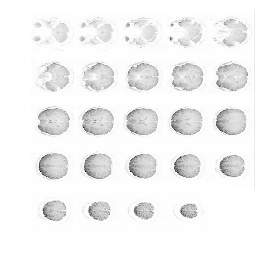

In [194]:
mos, _ = cortex.mosaic(input_funcref_voxeldata, dim=2);
mos[np.isnan(mos)] = 0
plt.pcolormesh(mos);

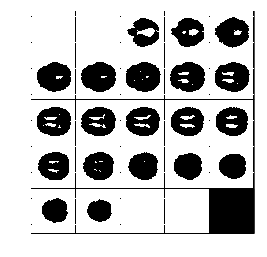

In [192]:
mos, _ = cortex.mosaic(gm_mask_vox, dim=2);
mos[np.isnan(mos)] = 0
plt.pcolormesh(mos);

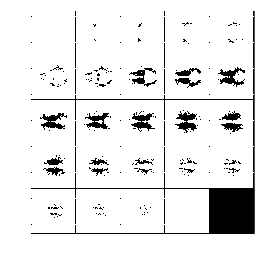

In [193]:
mos, _ = cortex.mosaic(wm_mask_vox, dim=2);
mos[np.isnan(mos)] = 0
plt.pcolormesh(mos);

# -----------------------------

In [236]:
# scans = []
# timepoints = []
# i = 0
for data_dir in data_dirs[3:]:
    print data_dir
    data_paths = glob(os.path.join(data_dir, '*.nii'))[7:-4]
    for data_path in data_paths:
        input_nifti1 = nbload(data_path)
        activity = wm.get_activity_in_masks(input_nifti1.get_data())
        gm_activity[i,:] = activity['gm']
        wm_activity[i,:] = activity['wm']
        i += 1
    timepoints.extend(data_paths)
    scans.extend([data_dir]*len(data_paths))

../benchmark_data/nifti_33
../benchmark_data/nifti_49
../benchmark_data/nifti_54
../benchmark_data/nifti_61
../benchmark_data/nifti_75
../benchmark_data/nifti_82
../benchmark_data/nifti_93


In [237]:
np.savez('activity.npz', wm=wm_activity, gm=gm_activity, timepoints=timepoints, scans=scans)

In [238]:
import pandas as pd

In [239]:
index = pd.MultiIndex.from_tuples(zip(
        map(lambda x: os.path.split(x)[-1], scans),
        map(lambda x: os.path.split(x)[-1], timepoints)
    ), names=['scan', 'timepoint'])

gm_df = pd.DataFrame(gm_activity, index=index)
wm_df = pd.DataFrame(wm_activity, index=index)

## Leave-one-out cross-validation
for each dataset, predict gray matter activation using a linear regression trained on remaining datasets

In [240]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

In [241]:
n_wm_pcs = 10

gm_detrend = []
for data_dir in data_dirs:
    test_scan = os.path.split(data_dir)[-1]
    train_iloc = wm_df.index.get_level_values('scan')!=test_scan
    wm_train = wm_df.iloc[train_iloc].values
    gm_train = gm_df.iloc[train_iloc].values
    
    wm_test = wm_df.iloc[~train_iloc].values
    gm_test = gm_df.iloc[~train_iloc].values

    n_trials, n_wm_voxels = wm_train.shape
    _, n_gm_voxels = gm_train.shape
    print data_dir,
    print 'pca',
    pca = PCA(n_components=n_wm_pcs)
    wm_train_pcs = pca.fit_transform(wm_train)
    
    print 'regression',
    model = LinearRegression()
    wm_test_pcs = model.fit(wm_train_pcs, gm_train)
    
    wm_test_pcs = pca.transform(wm_test)
    gm_trend = model.predict(wm_test_pcs)
    print 'done'
    gm_detrend.append(gm_test-gm_trend)

../benchmark_data/nifti_07 pca regression done
../benchmark_data/nifti_18 pca regression done
../benchmark_data/nifti_28 pca regression done
../benchmark_data/nifti_33 pca regression done
../benchmark_data/nifti_49 pca regression done
../benchmark_data/nifti_54 pca regression done
../benchmark_data/nifti_61 pca regression done
../benchmark_data/nifti_75 pca regression done
../benchmark_data/nifti_82 pca regression done
../benchmark_data/nifti_93 pca regression done


In [242]:
gm_detrend = np.asarray(gm_detrend)

save predictions

In [243]:
np.savez('gm_detrend_xval.npz', gm_detrend=gm_detrend)

### Load predictions

In [5]:
gm_detrend = np.load('gm_detrend_xval.npz')['gm_detrend']

## Compare to offline preprocessed data

In [6]:
import h5py

In [8]:
tab = h5py.File('../../benchmark_data/20140802JG_avsnr_2000ms_cache.hdf')

In [9]:
gm_offline = tab['reps'].value.T.swapaxes(1,2)

In [10]:
def voxel_set_explainable_variance(data, ncorrection=True, dozscore=True):
    '''
    Compute explainable variance for a set of voxels. This
    is a slightly faster implementation that depends on
    each repeat time-course being z-scored.

    Parameters
    ----------
    data (3D np.array (n, t, v))
        Contains the data time courses:
        1st axis: repeat
        2nd axis: time-course
        3rd axis: voxel index
    ncorrection (bool)
        Perform bias correction based on number of repetitions
    dozscore (bool)
        z-score the data in time. This is crucial. Only set to
        ``False`` if your data time courses are already z-scored.
        If unsure, set to ``True``

    Returns
    -------
    ev (1D np.array (v,))
        Explainable variance per voxel

    Note
    -----
    If ``dozscore=False``, make sure ``data`` is already z-scored!

    Example
    -------
    >>> np.random.seed(33)
    >>> data = np.random.randn(10, 100, 5)
    >>> vox = data[...,0]
    >>> vox.shape
    (10, 100)
    >>> voxel_mean_explainable_variance(zscore(vox.T), biascorr=False)
    0.087623222602840611
    >>> voxel_set_explainable_variance(vox, ncorrection=False)
    array([ 0.08762322])
    >>> # very voxels, amaze
    >>> voxel_set_explainable_variance(data, ncorrection=False)
    array([ 0.08762322,  0.08828303,  0.09716226,  0.11763627,  0.10860544])
    >>> voxel_mean_explainable_variance(vox.T, biascorr=False)
    0.085751866806535793
    >>> # Does not work if data is not zscored!
    >>> voxel_set_explainable_variance(vox, ncorrection=False, dozscore=False)
    array([ 0.13061663])
    >>> voxel_mean_explainable_variance(zscore(vox.T), biascorr=True)
    -0.013751974885732654
    >>> voxel_set_explainable_variance(vox, ncorrection=True)
    array([-0.01375197])

    '''


    if data.ndim == 2:
        # Fine, let's handle single voxels
        data = data[...,None]

    if dozscore:
        from scipy.stats import zscore
        data = zscore(data, 1)

    residual = data - data.mean(0)
    residualvar = np.mean(residual.var(1), 0)
    ev = 1 - residualvar

    if ncorrection:
        ev = ev - ((1 - ev) / np.float((data.shape[0] - 1)))
    return ev

In [11]:
ev_offline = voxel_set_explainable_variance(gm_offline)
ev_realtime = voxel_set_explainable_variance(gm_detrend)

mean explained variance
 offline:0.0355
 realtime:0.0342


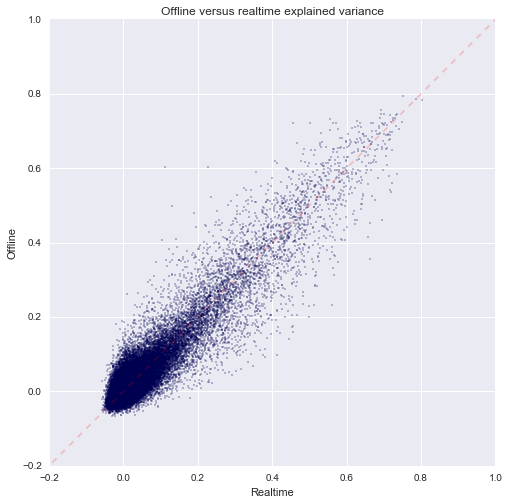

In [12]:
fig, ax = plt.subplots(figsize=(8,8));
ax.set_aspect('equal');
ax.scatter(ev_offline, ev_realtime, s=0.5);
ax.plot([-0.4,1],[-0.4,1], c='r', ls='--', alpha=0.2);
ax.set_xlim([-0.2,1]);
ax.set_ylim([-0.2,1]);
ax.set_ylabel('Offline');
ax.set_xlabel('Realtime');
ax.set_title('Offline versus realtime explained variance');

print 'mean explained variance\n offline:%.4f\n realtime:%.4f' % (ev_offline.mean(), ev_realtime.mean())

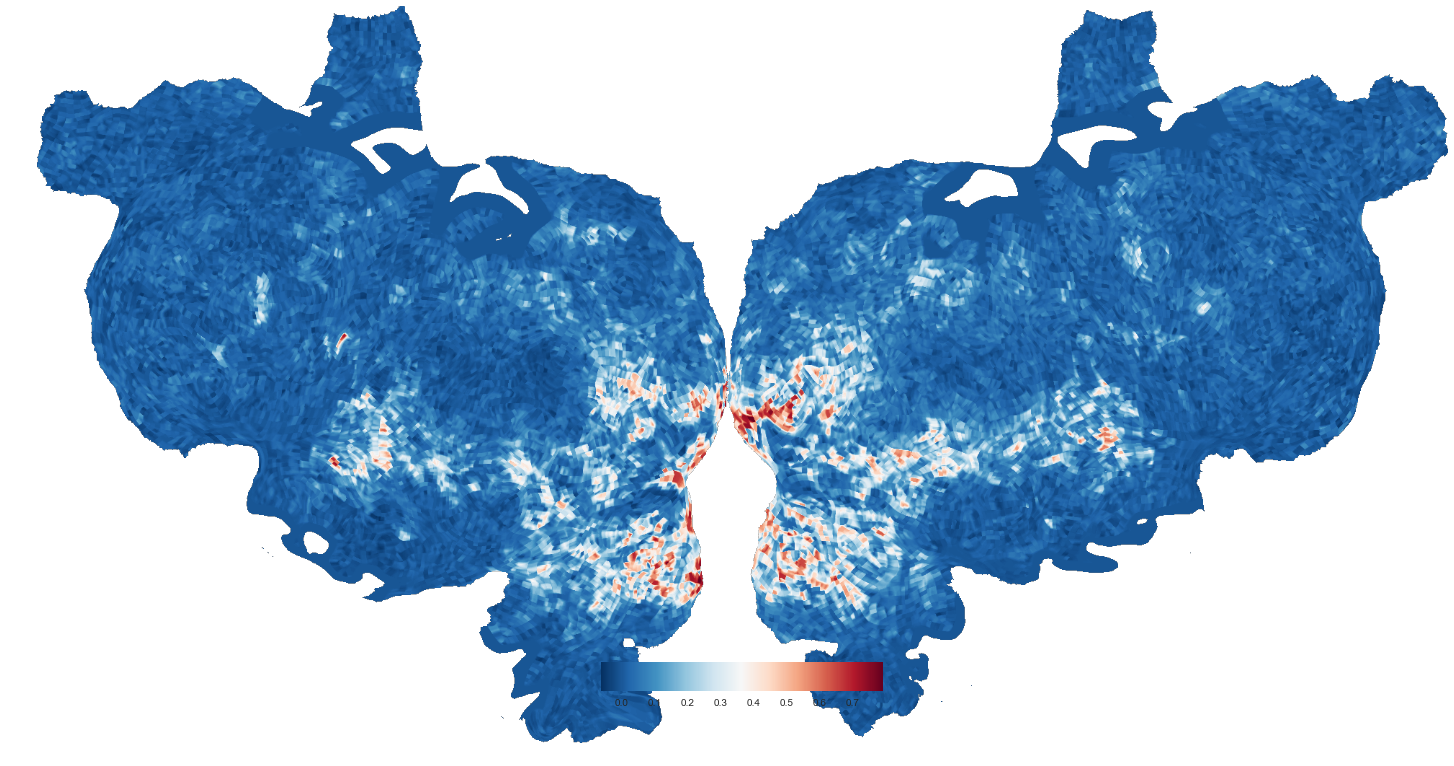

In [13]:
cortex.quickshow(cortex.Volume(ev_realtime, 'S1', '20140802JG_avsnr_auto'));

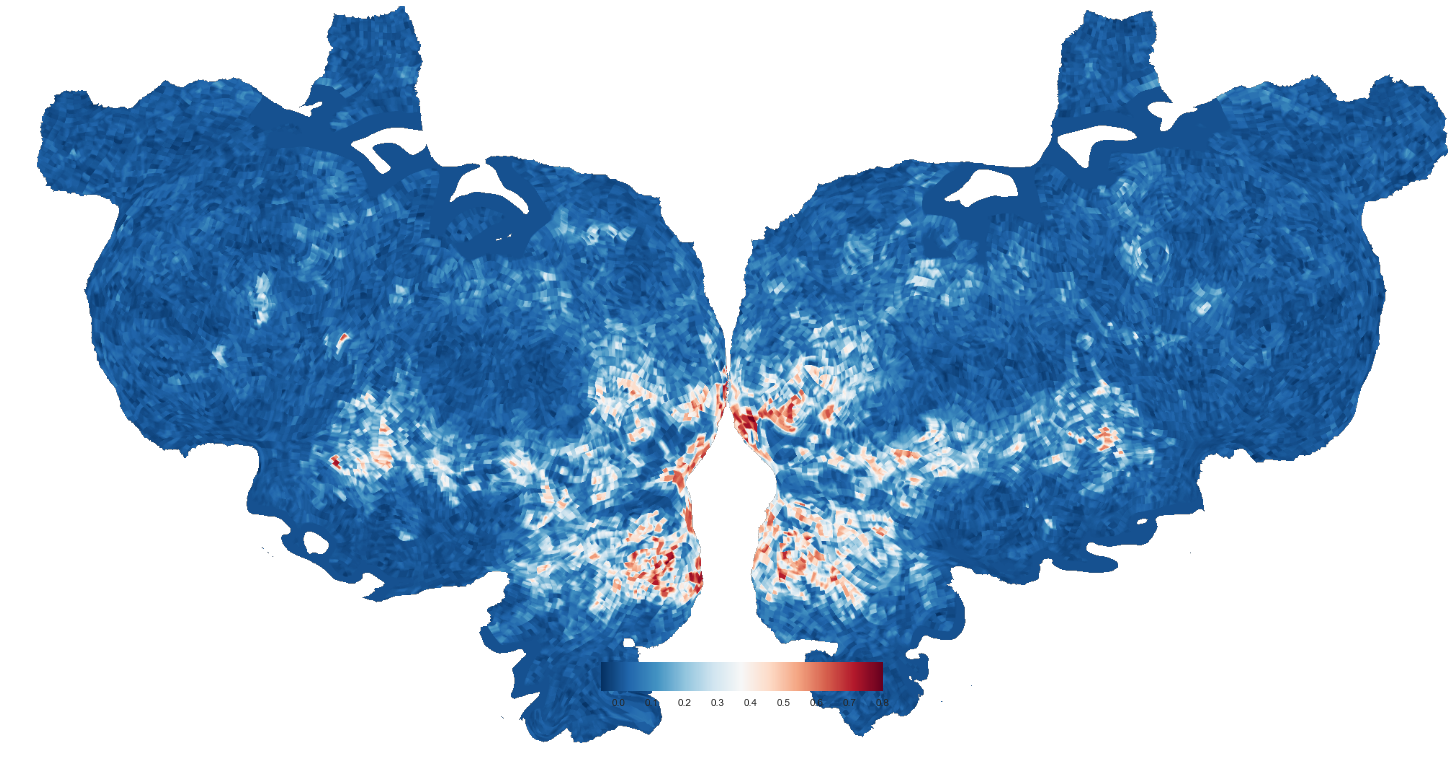

In [14]:
cortex.quickshow(cortex.Volume(ev_offline, 'S1', '20140802JG_avsnr_auto'));

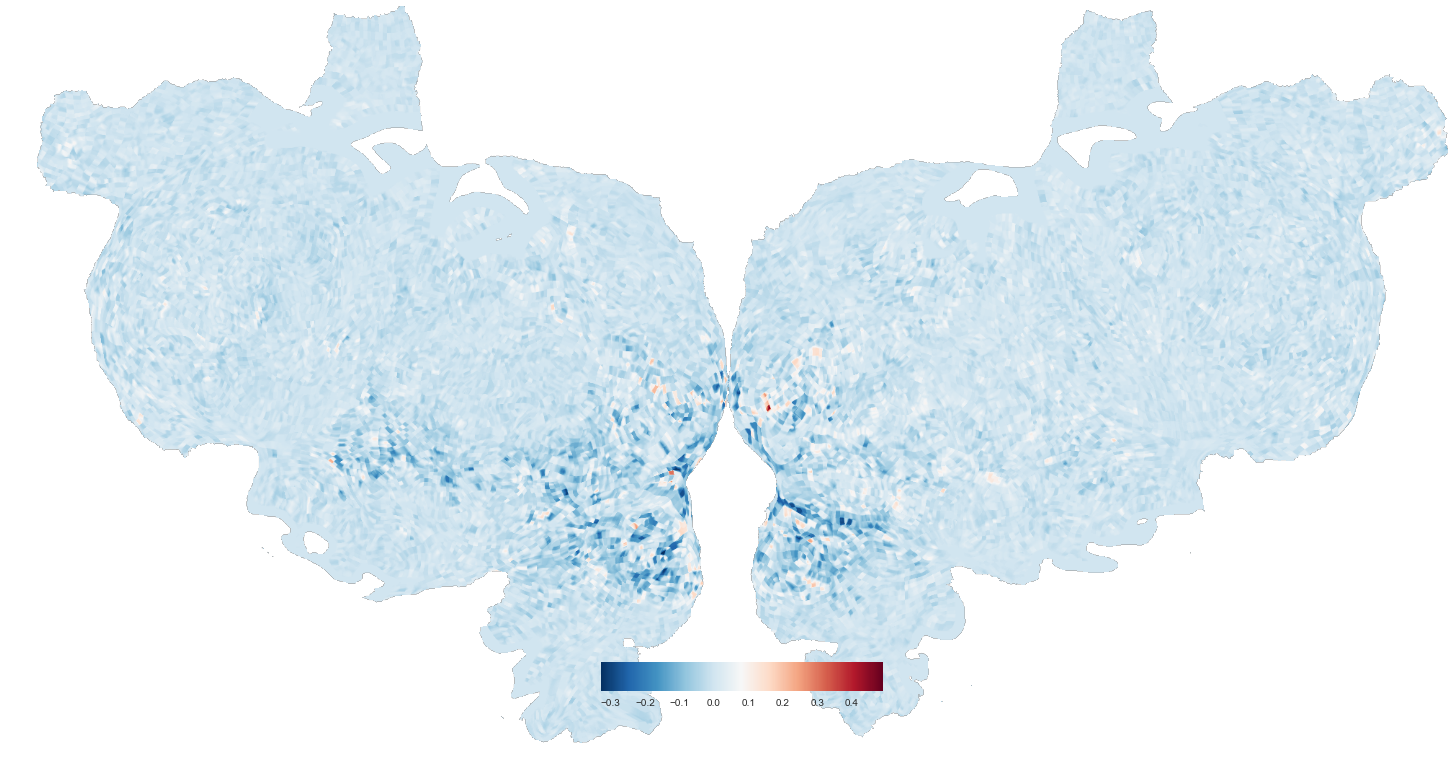

In [15]:
cortex.quickshow(cortex.Volume(ev_realtime-ev_offline, 'S1', '20140802JG_avsnr_auto'));

# Train using full dataset
And save model and pca to disk

In [272]:
model, pca = wm.train(gm_activity, wm_activity)

In [275]:
import cPickle
import time

In [294]:
model_fpath = 'model-%s.pkl'%time.strftime('%y-%m-%d-%H-%M-%S')
print model_fpath

with open(os.path.join('../realtimefmri/database/S1/',
                       model_fpath), 'w') as f:
    cPickle.dump(model, f)

model-15-12-21-21-17-02.pkl


In [295]:
pca_fpath = 'pca-%s.pkl'%time.strftime('%y-%m-%d-%H-%M-%S')
print pca_fpath

with open(os.path.join('../realtimefmri/database/S1/',
                       pca_fpath), 'w') as f:
    cPickle.dump(pca, f)

pca-15-12-21-21-17-03.pkl


# Convert folders of DICOM images

In [127]:
scan_dirs = glob('../benchmark_data/mb1_r11a_24sl_2000ms_*')

for i, scan_dir in enumerate(scan_dirs[2:]):
    abs_path, _ = os.path.split(scan_dir)
    folder_num = int(scan_dir.split('mb1_r11a_24sl_2000ms_')[-1])
    output_path = os.path.join(abs_path, 'nifti_%2.2i'%folder_num)
    args = [
            {
                'flag': 'o',
                'value': output_path
            },
            {
                'flag': 'n'
            },
            {
                'flag': 'f',
                'value': 'nifti'
            },
            {
                'position': 'last',
                'value': scan_dir
            }

        ]
    cmd = generate_command('mcverter', args)
    print ' '.join(cmd)
    subprocess.call(cmd)